<a href="https://colab.research.google.com/github/shrashti-19/Face-Recognition-System/blob/main/CVPR_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opencv-python face_recognition scikit-learn


In [2]:
# Set up Kaggle API credentials
import os
from google.colab import files
files.upload()  # Upload kaggle.json here

os.environ['KAGGLE_CONFIG_DIR'] = "/content"
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Install the Kaggle CLI
!pip install kaggle

# Download the LFW dataset
!kaggle datasets download -d atulanandjha/lfwpeople

# Unzip the dataset
!unzip lfwpeople.zip -d /content/lfw


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/atulanandjha/lfwpeople
License(s): GNU Lesser General Public License 3.0
lfwpeople.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  lfwpeople.zip
replace /content/lfw/lfw-funneled.tgz? [y]es, [n]o, [A]ll, [N]one, [r]ename: [r]
error:  invalid response [[r]]
replace /content/lfw/lfw-funneled.tgz? [y]es, [n]o, [A]ll, [N]one, [r]ename: [y]
error:  invalid response [[y]]
replace /content/lfw/lfw-funneled.tgz? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/lfw/lfw-funneled.tgz  
replace /content/lfw/pairs.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/lfw/pairs.txt  
replace /content/lfw/pairsDevTest.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/lfw/pairsDevTest.txt  
replace /content/lfw/pairsDevTrain.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/lfw/pairsDevTrain.txt  


In [3]:
import os
from collections import defaultdict

lfw_dir = '/content/lfw/lfw_funneled'
person_image_count = defaultdict(int)

# Count number of images per person
for person in os.listdir(lfw_dir):
    person_path = os.path.join(lfw_dir, person)
    if os.path.isdir(person_path):
        person_image_count[person] = len(os.listdir(person_path))

# Sort and pick top 5
top_5_people = sorted(person_image_count, key=person_image_count.get, reverse=True)[:5]
print("Top 5 people with most images:", top_5_people)


Top 5 people with most images: ['George_W_Bush', 'Colin_Powell', 'Tony_Blair', 'Donald_Rumsfeld', 'Gerhard_Schroeder']


In [4]:
## load images for 5 people
import cv2
import numpy as np

X = []
y = []

for idx, person in enumerate(top_5_people):
    person_path = os.path.join(lfw_dir, person)
    for image_name in os.listdir(person_path):
        image_path = os.path.join(person_path, image_name)
        image = cv2.imread(image_path)
        if image is not None:
            image = cv2.resize(image, (64, 64))
            X.append(image)
            y.append(idx)  # Encode person as a number

X = np.array(X)
y = np.array(y)

print(f"Dataset shape: {X.shape}, Labels shape: {y.shape}")


Dataset shape: (1140, 64, 64, 3), Labels shape: (1140,)


In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [6]:
# Step 4: Normalize and Build Model

X_train = X_train / 255.0
X_test = X_test / 255.0


In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(top_5_people), activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       802,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 822,597 (3.14 MB)

 Trainable params: 822,597 (3.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 303ms/step - accuracy: 1.0000 - loss: 6.1396e-04 - val_accuracy: 0.8772 - val_loss: 0.5804
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 246ms/step - accuracy: 1.0000 - loss: 6.7526e-04 - val_accuracy: 0.8772 - val_loss: 0.5934
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 190ms/step - accuracy: 1.0000 - loss: 5.5302e-04 - val_accuracy: 0.8728 - val_loss: 0.6119
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 238ms/step - accuracy: 1.0000 - loss: 5.2789e-04 - val_accuracy: 0.8772 - val_loss: 0.6232
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 181ms/step - accuracy: 1.0000 - loss: 4.3729e-04 - val_accuracy: 0.8772 - val_loss: 0.6030
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 11s 213ms/step - accuracy: 1.0000 - loss: 3.4612e-04 - val_accuracy: 0.8728 - val_loss: 0.6439
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 191ms/step - accuracy: 1.0000 - loss: 3.1550e-04 - val_accuracy: 0.8772 - val_loss: 0.6351
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 197ms/step - accuracy: 1.0000 - l

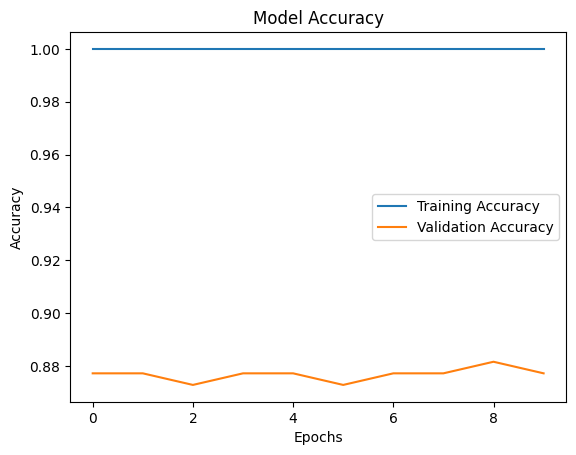

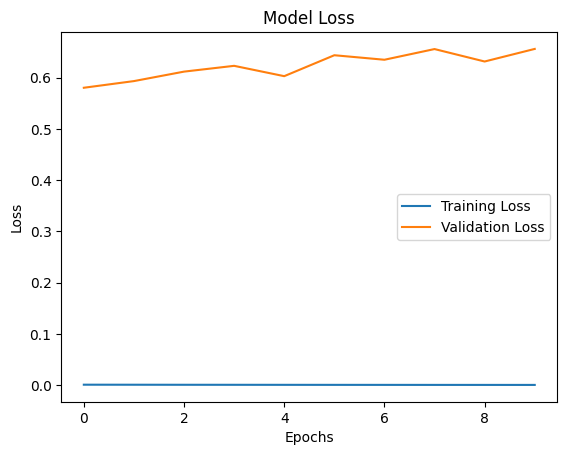

In [19]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [20]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.2f}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.8818 - loss: 0.5876
Test Accuracy: 0.88


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


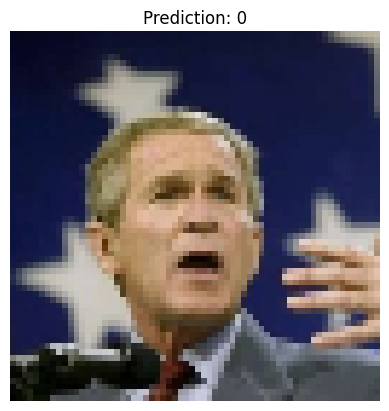

Predicted Person: 0
Classes in y_train: [0 1 2 3 4]


In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Load and resize the image
test_img_path = "/content/lfw/lfw_funneled/George_W_Bush/George_W_Bush_0003.jpg"
test_img = cv2.imread(test_img_path)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
test_img_resized = cv2.resize(test_img, (64, 64))  # Match training size

# Normalize pixel values and reshape to (1, 64, 64, 3)
test_img_array = test_img_resized.astype('float32') / 255.0
test_img_input = np.expand_dims(test_img_array, axis=0)

# Predict
predicted_label = model.predict(test_img_input)
predicted_class = np.argmax(predicted_label)

# Assuming you have 'y_train' available (labels from the training dataset)
# Fit the LabelEncoder on y_train
label_encoder = LabelEncoder()
label_encoder.fit(y_train)  # Fit on original y labels

# Inverse transform to get the name corresponding to the predicted index
predicted_name = label_encoder.inverse_transform([predicted_class])[0]

# Display the result
plt.imshow(test_img_resized)
plt.title(f"Prediction: {predicted_name}")
plt.axis('off')
plt.show()

print(f"Predicted Person: {predicted_name}")
print("Classes in y_train:", label_encoder.classes_)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


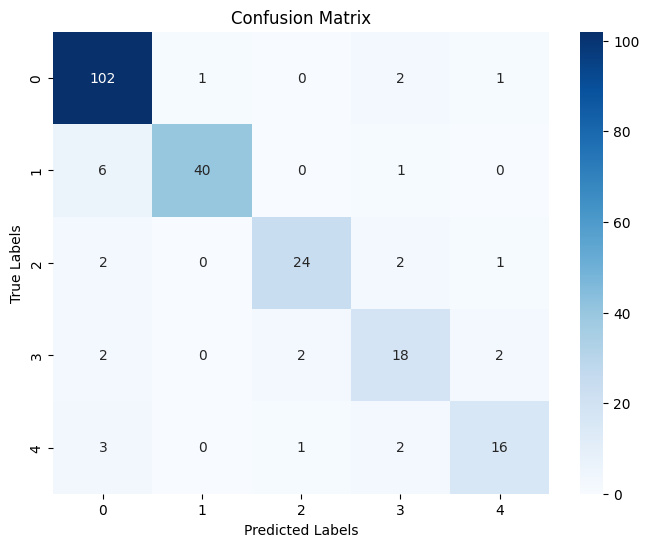

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get predictions for the entire test set
test_predictions = model.predict(X_test)  # Replace X_test with your test images
predicted_classes = np.argmax(test_predictions, axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_test, predicted_classes)  # Replace y_test with actual labels
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
